In [1]:
import json
import pickle
import string

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

import torch
import torch.nn

from morpho_tagging.networks import *
from morpho_tagging.train import parser


In [4]:
# Paths to model outputs
model_root = "/home/virginia/workspace/CS682_NNs_Nerual_Char_Models_Russian/language_models"
model_name = "conv_batch20_dropout0.25_charembedsize50_learningrate0.001_activationleakyrelu"
best_model = f"{model_root}/{model_name}/tagger_ru_data_17_Nov_2021_02_07_09_best"
model_settings = f"{model_root}/{model_name}/tagger_ru_settings_17_Nov_2021_02_07_09"
char_vocab_path = f"{model_root}/{model_name}/tagger_ru_charvocab_17_Nov_2021_02_07_09"
word_vocab_path = f"{model_root}/{model_name}/tagger_ru_wordvocab_17_Nov_2021_02_07_09"

In [5]:
device="cpu"
load_params = parser.parse_args(["--training_type", "lm", "--data_path_ud", "dummy", "--save_dir", "dummy", "--pretrained_model", best_model, "--pretrained_settings", model_settings])

with open(load_params.pretrained_settings) as settings_in:
    print("Loading model settings")
    settings_json = json.load(settings_in)
    for k in settings_json:
        if k != 'pretrained_model':
            setattr(load_params, k, settings_json[k])
        if k == "tagset_size":
            tagset_sizes = {}
            for a, v in settings_json[k].items():
                tagset_sizes[int(a)]=v
            setattr(load_params, k, tagset_sizes)
        
print(load_params)

model = Tagger(load_params, device)
model.load_state_dict(torch.load(load_params.pretrained_model, map_location=torch.device('cpu')))

with open(char_vocab_path, 'rb') as vocab_in:
    char_vocab = pickle.load(vocab_in)

with open(word_vocab_path, 'rb') as words_in:
    word_vocab = pickle.load(words_in)


Loading model settings
Namespace(batch_size=20, char_conv_act='leakyrelu', char_embedding_size=50, char_filter_sizes=[1, 2, 3, 4, 5, 6], char_gram=1, char_number_of_filters=[25, 50, 75, 100, 125, 150], char_rec_num_units=100, char_type='conv', char_vocab_size=185, data_path_ud='../CS682_NNs_Nerual_Char_Models_Russian/data', dropout_frac=0.25, language='ru', lm_hidden_size=100, lm_num_layers=1, lr=0.001, num_epochs=10, pad_index=0, pretrained_model='/home/virginia/workspace/CS682_NNs_Nerual_Char_Models_Russian/language_models/conv_batch20_dropout0.25_charembedsize50_learningrate0.001_activationleakyrelu/tagger_ru_data_17_Nov_2021_02_07_09_best', pretrained_settings=None, save_dir='../CS682_NNs_Nerual_Char_Models_Russian/language_models/conv_batch20_dropout0.25_charembedsize50_learningrate0.001_activationleakyrelu', save_file='tagger_ru_', tagset_size={0: 20}, training_type='lm', unique_words=0, word_vocab_size=140768)


In [6]:
# Get CharEmbeddings from model 
char_embedding_weights = model.char_embeddings.weight.detach().numpy()

In [7]:
char_pca = PCA(2)
char_pca_proj = char_pca.fit_transform(char_embedding_weights)
char_pca_proj[:5]

array([[-0.5578385 ,  0.19498669],
       [-0.5607538 ,  0.19400142],
       [-0.5433909 ,  0.19267683],
       [-0.51270515,  0.15550637],
       [-0.38709912, -0.11091244]], dtype=float32)

In [8]:
tsne = TSNE(2)
char_tsne_proj = tsne.fit_transform(char_embedding_weights)
char_tsne_proj[:5]

/home/virginia/miniconda3/envs/682_final_proj/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/virginia/miniconda3/envs/682_final_proj/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


array([[4.604411  , 1.2154655 ],
       [4.624055  , 1.216179  ],
       [4.574027  , 1.2058569 ],
       [4.7011786 , 1.2009557 ],
       [3.323352  , 0.92697835]], dtype=float32)

In [9]:
def get_char_class(char):
    """Returns 'digit', 'upper', 'lower', 'punct' or 'special' 
    """
    if char.isdigit():
        return 'digit'
    if char in ["<unk>", "<pad>", "<special_token>", "<eow>", "<sow>", "<eos>", "<sos>"]:
        return 'special'
    if char.isupper():
        return 'upper'
    if char.islower():
        return 'lower'
    if char in string.punctuation:
        return 'punctuation'
    else:
        return 'symbol'

In [10]:
# build dataframe
entries = []
for k, char_idx in char_vocab.char_to_index.items():
    char_type = get_char_class(k)
    entries.append((k, char_idx, char_type, char_pca_proj[char_idx][0], char_pca_proj[char_idx][1], char_tsne_proj[char_idx][0], char_tsne_proj[char_idx][1]))

char_plot_df = pd.DataFrame.from_records(entries, columns=["char", "embedding_index", "char_class", "pca_x", "pca_y", "tsne_x", "tsne_y"])
        

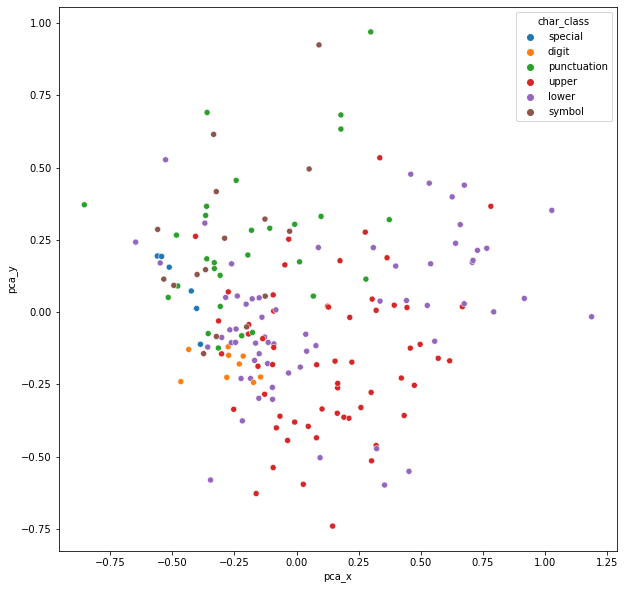

In [13]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data = char_plot_df, x="pca_x", y="pca_y", hue="char_class")
#for k, char_idx in char_vocab.char_to_index.items():
#    ax.text(char_pca_proj[char_idx][0], char_pca_proj[char_idx][1], k)

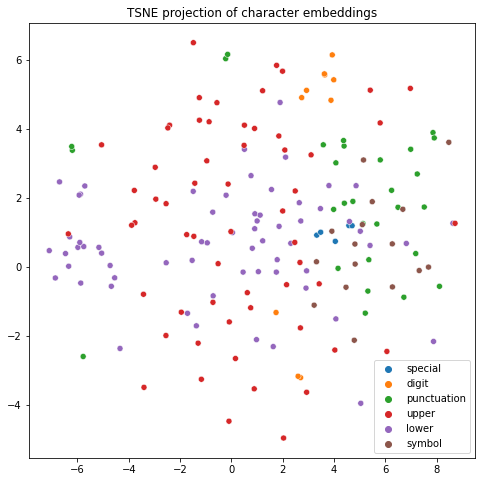

In [12]:
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(data = char_plot_df, x="tsne_x", y="tsne_y", hue="char_class")
#for k, char_idx in char_vocab.char_to_index.items():
#    ax.text(char_tsne_proj[char_idx][0], char_tsne_proj[char_idx][1], k)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set(title="TSNE projection of character embeddings")
ax.get_legend().set_title("Character class")
plt.legend(loc='lower right')

In [20]:
# Get embeddings for all words in the training data
def get_word_embedding_input_batch(word_vocab, char_vocab, model, word_embedding_size):
    """Returns the embeddings as (word_vocab_size, embedding_size) np array, where the 
    embedding for a word is at the same index assigned to the word in the word vocab. 
    The returned array can be fed to distance metrics up nearest neighbors in the learned word vocabulary.
    """
    lengths = [1, 1, 1] # Lengths for padding, start and end of sentence
    print("Word to index size:", len(word_vocab.word_to_index))
    index_to_word = {v:k for k, v in word_vocab.word_to_index.items()}
    print("Index to word size:", len(index_to_word))
    print("Those two numbers should match")
    max_length = max([len(v) for v in word_vocab.word_to_char_embedding.values()])
    words_in = np.zeros((word_vocab.vocab_size(), max_length))
    print(words_in.shape)
    # Start and end of sentence
    words_in[1][0:1] = np.array(char_vocab.char_to_index["<sos>"])
    words_in[2][0:1] = np.array(char_vocab.char_to_index["<eos>"])
    for w, idx in word_vocab.word_to_index.items():
        embedding = word_vocab.word_to_char_embedding[w]
        emb_len = len(embedding)
        lengths.append(emb_len)
        words_in[idx][0:emb_len] = np.array(embedding)
    print(len(words_in))

    model.eval()
    word_embedding_batches = []
    # Break up words in vocab into smaller batches so there aren't any memory issues
    word_char_batches = np.array_split(words_in, word_embedding_size)
    start = 0
    for b in word_char_batches:
        end = start+ b.shape[0]
        if start % 50==0: print("Batch from", start, "to", end)
        batch_emb = model.get_word_embeddings(b, np.array(lengths[start:end])).detach().numpy()
        if batch_emb.shape[0] != (b.shape[0]):
            print("Batch doesn't match, start:", start, "end:", end)
        word_embedding_batches.append(batch_emb)
        start = end

    word_embeddings = np.vstack(word_embedding_batches)
    print("Embedding shape:", word_embeddings.shape)
    return word_embeddings



In [21]:
word_embeddings = get_word_embedding_input_batch(word_vocab, char_vocab, model, 525)

Word to index size: 140765
Index to word size: 140765
Those two numbers should match
(140768, 101)
140768
Batch from 0 to 269
Batch from 13450 to 13719
Batch from 19900 to 20168
Batch from 26600 to 26868
Batch from 33300 to 33568
Batch from 40000 to 40268
Batch from 46700 to 46968
Batch from 53400 to 53668
Batch from 60100 to 60368
Batch from 66800 to 67068
Batch from 73500 to 73768
Batch from 80200 to 80468
Batch from 86900 to 87168
Batch from 93600 to 93868
Batch from 100300 to 100568
Batch from 107000 to 107268
Batch from 113700 to 113968
Batch from 120400 to 120668
Batch from 127100 to 127368
Batch from 133800 to 134068
Batch from 140500 to 140768
Embedding shape: (140768, 525)


In [22]:
from sklearn.metrics.pairwise import cosine_similarity

def get_most_similar_words(word, word_embeddings, word_vocab, n=10):
    """Given a word, looks up its index in the word_vocab, then returns a list
    of the n most similar words using cosine similarity of the word embeddings
    produced by the model.
    """
    word_idx = word_vocab.word_to_index[word]
    print("Word:", word, "Index:", word_idx)
    this_embedding = word_embeddings[word_idx].reshape(1, -1)
    similarities = cosine_similarity(this_embedding, word_embeddings)
    # Note that this sorts in increasing order, so the most similar are at the end
    most_similar_idx = np.argsort(similarities, axis=1).reshape(-1)
    idx_to_word = {v:k for k,v in word_vocab.word_to_index.items()}
    word_list = []
    for i in range(n):
        word_list.append(idx_to_word[most_similar_idx[-(i+2)]])

    print(word_list)
    return word_list
    

In [23]:
word_list = ['большой', 'большая', 'мужчина', "женщина", 'женщины', "Москва", "говорить", "говоришь", "меня", "мне", "тебя", "тебе", "весна", "этот", "это", 'этой', 'эта', 'быть', 'было', 'в', 'красный', 'красная', 'красном', '?', '.', "любовь", "любви", "любить", "любила", "сказать", "рассказывать", "разговор", "привет", "спасибо", "нет", "хорошо", "хороший", "Саша", "ночь", "день", "днём", "и", "а", "но", "ну", "я", "он", "его", "она", "ее", "её", 'Россия', "России", "здравствуйте", "здравствуй", "книга", "книги", "собака", "собак", "собаки", "кошка", "кошки", "кошек", "когда", "где", "который", "которой"]

for w in word_list: 
    get_most_similar_words(w, word_embeddings, word_vocab)



Word: большой Index: 577
['небольшой', 'Небольшой', 'сверхбольшой', 'дельной', 'начальной', 'незначительной', 'необязательной', 'печальной', 'сдельной', 'стельной']
Word: большая Index: 1347
['бОльшая', 'небольшая', 'наибольшая', 'Небольшая', 'тяжелейшая', 'Пожелтевшая', 'бывшая', 'новейшая', 'ставшая', 'вручившая']
Word: мужчина Index: 2209
['города', 'пустынна', 'Нигматуллина', 'тулупа', 'заминка', 'гусака', 'горку', 'коммуналка', 'эллина', 'мужчину']
Word: женщина Index: 603
['женщину', 'колготина', 'сплина', 'лещина', 'эллина', 'дельфина', 'инсулина', 'начфина', 'слеза', 'сингониума']
Word: женщины Index: 3939
['мины', 'общины', 'коммуны', 'лавины', 'паутины', 'балясины', 'длинны', 'дельфины', 'бегуны', 'половины']
Word: Москва Index: 4677
['Москва-река', 'Морозова', 'Мордюкова', 'Мольера', 'Кириллова', 'Диброва', 'Чувства', 'Мосгорсправка', 'Кольцова', 'Кирова']
Word: говорить Index: 639
['говорили', 'говорят', 'говорит', 'говорила', 'уговорили', 'уговорила', 'говорите', 'оговорит